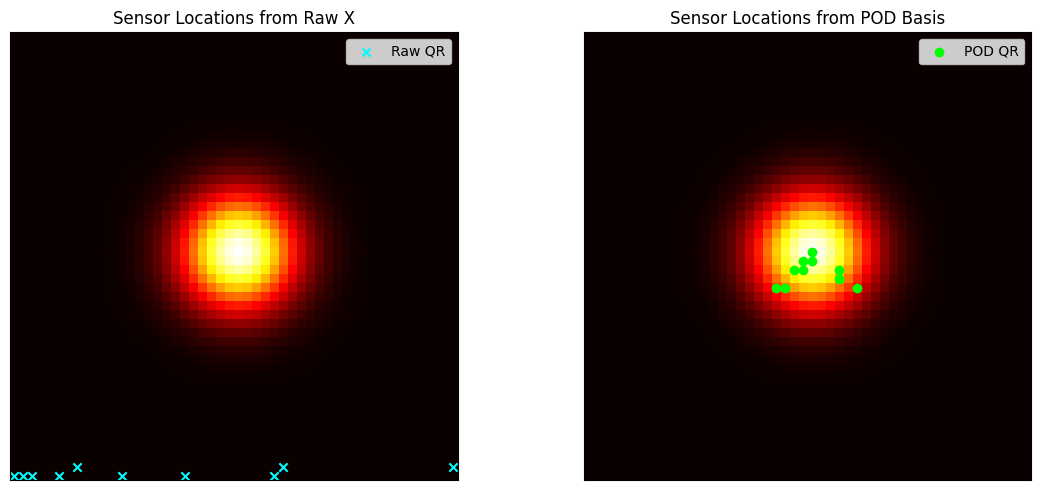

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import qr, svd

# Parameters for 2D heat diffusion
nx, ny = 50, 50  # grid size
nt = 100         # number of time steps
dx = dy = 1.0
alpha = 1.0
dt = 0.1
dx2 = dx * dx
dy2 = dy * dy
k = alpha * dt / dx2

# Initial condition: hot spot in the center
u = np.zeros((nx, ny))
u[nx//2, ny//2] = 100.0

# Storage for flattened frames
X = np.zeros((nx * ny, nt))

# Time stepping using explicit finite difference
for t in range(nt):
    u_new = u.copy()
    u_new[1:-1, 1:-1] = u[1:-1, 1:-1] + k * (
        u[2:, 1:-1] + u[:-2, 1:-1] + u[1:-1, 2:] + u[1:-1, :-2] - 4*u[1:-1, 1:-1]
    )
    u = u_new.copy()
    X[:, t] = u.flatten()

# QR on raw X
_, _, pivots_raw = qr(X, pivoting=True)

# QR on POD basis
U, _, _ = svd(X, full_matrices=False)
Psi_r = U[:, :20]
_, _, pivots_pod = qr(Psi_r.T, pivoting=True)

# Reshape top pivot points into 2D coordinates for visualization
def pivot_indices_to_coords(pivots, nx, ny, num=10):
    coords = [(p % nx, p // nx) for p in pivots[:num]]
    return np.array(coords)

coords_raw = pivot_indices_to_coords(pivots_raw, nx, ny)
coords_pod = pivot_indices_to_coords(pivots_pod, nx, ny)

# Plot heatmap and overlay sensor locations
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].imshow(X[:, -1].reshape(nx, ny), cmap='hot', origin='lower')
ax[0].scatter(coords_raw[:, 0], coords_raw[:, 1], c='cyan', marker='x', label='Raw QR')
ax[0].set_title("Sensor Locations from Raw X")

ax[1].imshow(X[:, -1].reshape(nx, ny), cmap='hot', origin='lower')
ax[1].scatter(coords_pod[:, 0], coords_pod[:, 1], c='lime', marker='o', label='POD QR')
ax[1].set_title("Sensor Locations from POD Basis")

for a in ax:
    a.legend()
    a.set_xticks([])
    a.set_yticks([])

plt.tight_layout()
plt.show()


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import qr, svd
import random
import pandas as pd

# Heat diffusion simulation
def simulate_heat_diffusion(nx=50, ny=50, nt=100, alpha=1.0, dt=0.1):
    dx = dy = 1.0
    dx2 = dx * dx
    k = alpha * dt / dx2
    u = np.zeros((nx, ny))
    u[nx // 2, ny // 2] = 100.0
    X = np.zeros((nx * ny, nt))
    for t in range(nt):
        u_new = u.copy()
        u_new[1:-1, 1:-1] = u[1:-1, 1:-1] + k * (
            u[2:, 1:-1] + u[:-2, 1:-1] + u[1:-1, 2:] + u[1:-1, :-2] - 4 * u[1:-1, 1:-1]
        )
        u = u_new.copy()
        X[:, t] = u.flatten()
    return X

# POD basis from SVD
def compute_pod_basis(X, r):
    U, _, _ = svd(X, full_matrices=False)
    return U[:, :r]

# Convert 2D (x,y) coords to flat index
def coords_to_flat_indices(coords, nx):
    return [y * nx + x for x, y in coords]

# Convert flat index to (x,y)
def flat_indices_to_coords(indices, nx):
    return np.array([(i % nx, i // nx) for i in indices])

# Extend preselected sensors with QR
def continue_qr_pivoting(Psi_r, preselected, total_sensors):
    all_indices = list(range(Psi_r.shape[0]))
    remaining = [i for i in all_indices if i not in preselected]
    Psi_remaining = Psi_r[remaining, :]
    _, _, pivots_remain = qr(Psi_remaining.T, pivoting=True)
    selected_remaining = [remaining[i] for i in pivots_remain[:total_sensors - len(preselected)]]
    return preselected + selected_remaining

# Reconstruct the full state from selected sensors
def reconstruct_from_sensors(X, Psi_r, sensor_indices):
    Y = X[sensor_indices, :]
    Psi_sub = Psi_r[sensor_indices, :]
    coef, _, _, _ = np.linalg.lstsq(Psi_sub, Y, rcond=None)
    return Psi_r @ coef

# Run comparison of sensor placement strategies
def run_random_preselection_trials(X, Psi_r, num_trials=5, fixed_count=3, total_sensors=10, nx=50):
    errors = []
    _, _, pivots_optimal = qr(Psi_r.T, pivoting=True)
    sensors_optimal = pivots_optimal[:total_sensors]
    X_rec_optimal = reconstruct_from_sensors(X, Psi_r, sensors_optimal)
    error_optimal = np.linalg.norm(X - X_rec_optimal, 'fro') / np.linalg.norm(X, 'fro')

    for trial in range(num_trials):
        all_indices = list(range(Psi_r.shape[0]))
        random_fixed = sorted(random.sample(all_indices, fixed_count))
        extended = continue_qr_pivoting(Psi_r, random_fixed, total_sensors)
        X_rec_extended = reconstruct_from_sensors(X, Psi_r, extended)
        error_extended = np.linalg.norm(X - X_rec_extended, 'fro') / np.linalg.norm(X, 'fro')

        errors.append({
            "Trial": trial + 1,
            "Random Fixed Indices": random_fixed,
            "Extended Indices": extended,
            "Reconstruction Error": error_extended
        })

    return error_optimal, errors

# === MAIN EXECUTION ===
if __name__ == "__main__":
    nx, ny, nt = 50, 50, 100
    r = 20
    num_trials = 5
    total_sensors = 10
    fixed_count = 3

    X = simulate_heat_diffusion(nx, ny, nt)
    Psi_r = compute_pod_basis(X, r)

    # Run trials
    error_optimal, random_trials = run_random_preselection_trials(
        X, Psi_r, num_trials=num_trials,
        fixed_count=fixed_count,
        total_sensors=total_sensors,
        nx=nx
    )

    # Create results table
    df_results = pd.DataFrame({
        "Trial": [entry["Trial"] for entry in random_trials],
        "Random Fixed Sensors": [entry["Random Fixed Indices"] for entry in random_trials],
        "Extended Sensors": [entry["Extended Indices"] for entry in random_trials],
        "Reconstruction Error": [entry["Reconstruction Error"] for entry in random_trials]
    })

    # Append optimal result
    df_results.loc[len(df_results)] = {
        "Trial": "Optimal (Full QR)",
        "Random Fixed Sensors": "-",
        "Extended Sensors": "-",
        "Reconstruction Error": error_optimal
    }

    # Display results
    print(df_results)


               Trial Random Fixed Sensors  \
0                  1       [39, 209, 962]   
1                  2      [17, 369, 2465]   
2                  3   [1138, 1950, 2360]   
3                  4   [1314, 1337, 1361]   
4                  5   [2085, 2184, 2330]   
5  Optimal (Full QR)                    -   

                                    Extended Sensors  Reconstruction Error  
0  [39, 209, 962, 1275, 1225, 1224, 1174, 1173, 1...              0.202084  
1  [17, 369, 2465, 1275, 1225, 1224, 1174, 1173, ...              0.202085  
2  [1138, 1950, 2360, 1275, 1225, 1224, 1174, 117...              0.202076  
3  [1314, 1337, 1361, 1275, 1225, 1224, 1174, 117...              0.201677  
4  [2085, 2184, 2330, 1275, 1225, 1224, 1174, 117...              0.202060  
5                                                  -              0.086016  
